# Simulation 5: Bimodal Dataset
Based on a Kaggle competition that can be found here: https://www.kaggle.com/code/iamleonie/handling-multimodal-distributions-fe-techniques#Data-Overview

In [74]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.datasets import make_friedman1
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import random
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import warnings
warnings.filterwarnings("ignore")


In [75]:
# Fill in the path where you downloaded the project or if the hole folder is open, leave it as it is. 
# Should print what in your folder is.
ROOT_PATH = '.'
print(os.listdir(ROOT_PATH))

['.git', '.gitignore', 'README.md', 'Requirements', 'Simulations', 'test.csv', 'train.csv', 'utils.py', 'utils_Nadja.py', '__pycache__']


In [76]:
from utils import generate_friedman1, to_dataframe, plot_data_3D, train_test_stratified, evaluate_rf, create_cont_folds
from utils_Nadja import fold_visualizer

In [77]:
# Configurations
N_SPLITS = 5
SEED = 42

train_df = pd.read_csv("train.csv")
display(train_df.head())

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


In [78]:
display(train_df.target.describe())

count    300000.000000
mean          7.905661
std           0.733071
min           0.000000
25%           7.329367
50%           7.940571
75%           8.470084
max          10.267569
Name: target, dtype: float64

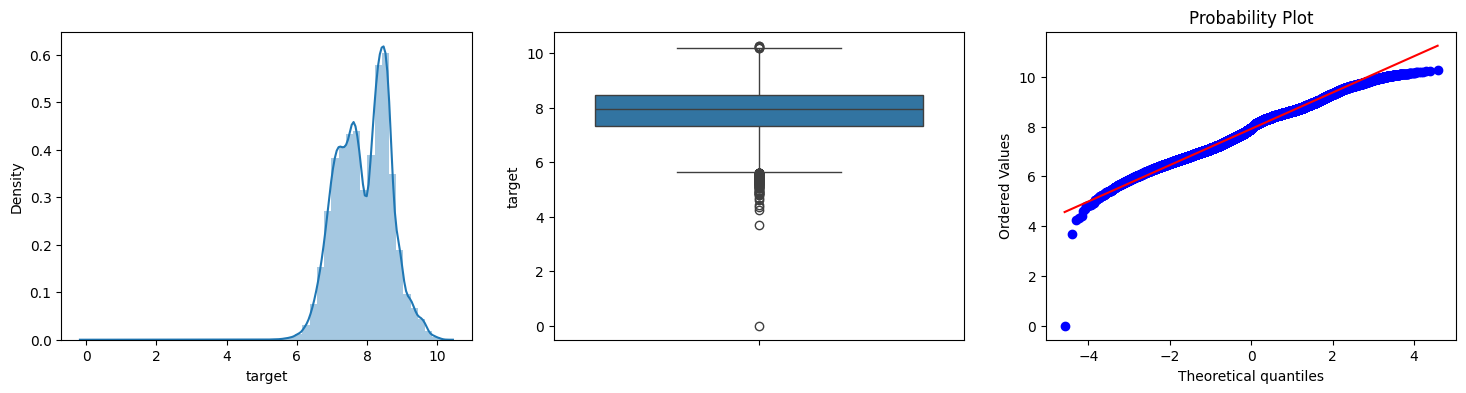

In [79]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
sns.distplot(train_df.target, ax=ax[0])
sns.boxplot(train_df.target, ax=ax[1])
stats.probplot(train_df['target'], plot=ax[2])
plt.show()

In [80]:
# Drop one outlier
train_df = train_df[train_df.target != 0].reset_index(drop=True)

In [81]:
train_df = train_df.sample(n=1000, axis=0, random_state=SEED).reset_index(drop=True)

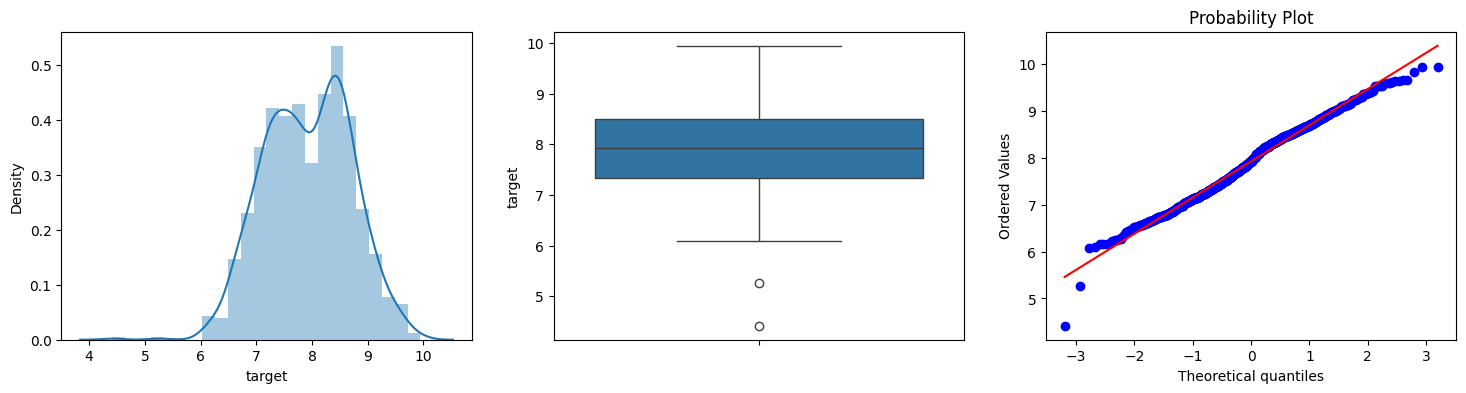

In [82]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
sns.distplot(train_df.target, ax=ax[0])
sns.boxplot(train_df.target, ax=ax[1])
stats.probplot(train_df['target'], plot=ax[2])
plt.show()

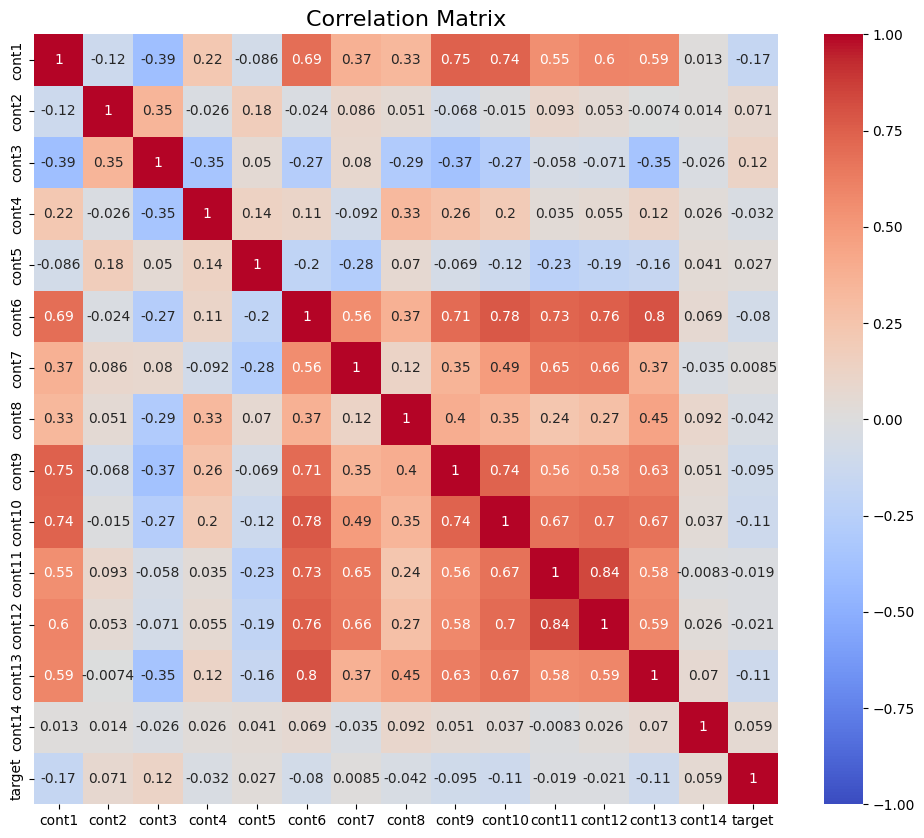

In [83]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title("Correlation Matrix", fontsize=16)
sns.heatmap(train_df[train_df.columns[train_df.columns != 'id']].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

plt.show()

### Random Forest without stratification

In [84]:
train_df.iloc[: , 1:-1]

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.519411,0.621359,0.662510,0.209457,0.312271,0.403386,0.594557,0.258249,0.423621,0.555895,0.433377,0.383627,0.393071,0.464706
1,0.247742,0.735924,0.570099,0.218188,0.282360,0.530950,0.444548,0.509719,0.298737,0.436126,0.409752,0.367431,0.614702,0.609812
2,0.359893,0.682071,0.954931,0.320520,0.587855,0.348260,0.479502,0.280610,0.378670,0.328168,0.482407,0.520471,0.260127,0.386427
3,0.478859,0.297634,0.490258,0.545006,0.283097,0.711054,0.567474,0.357818,0.432279,0.566171,0.695979,0.687040,0.758776,0.296917
4,0.146143,0.737297,0.631521,0.778118,0.283099,0.230724,0.214004,0.539120,0.160490,0.262755,0.296458,0.204522,0.510772,0.382725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.661732,0.056421,0.279991,0.246340,0.780187,0.646250,0.536967,0.733605,0.375669,0.526415,0.388269,0.318411,0.686646,0.626176
996,0.564324,0.558623,0.630507,0.206197,0.311615,0.438065,0.575669,0.280280,0.350351,0.446673,0.555086,0.624272,0.360944,0.387402
997,0.420054,0.137825,0.549224,0.275048,0.283626,0.368201,0.266482,0.442836,0.358265,0.391126,0.247797,0.251060,0.316331,0.623368
998,0.648689,0.680543,0.233894,0.474324,0.726738,0.601291,0.426188,0.638361,0.578830,0.373679,0.303995,0.353822,0.617419,0.416725


In [85]:
# first devide data in train/test data (80/20 ratio)
X_train, X_test, y_train, y_test = train_test_split(train_df.iloc[: , 1:-1], 
                                                    train_df['target'], 
                                                    test_size=0.2, 
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 14) (200, 14) (800,) (200,)


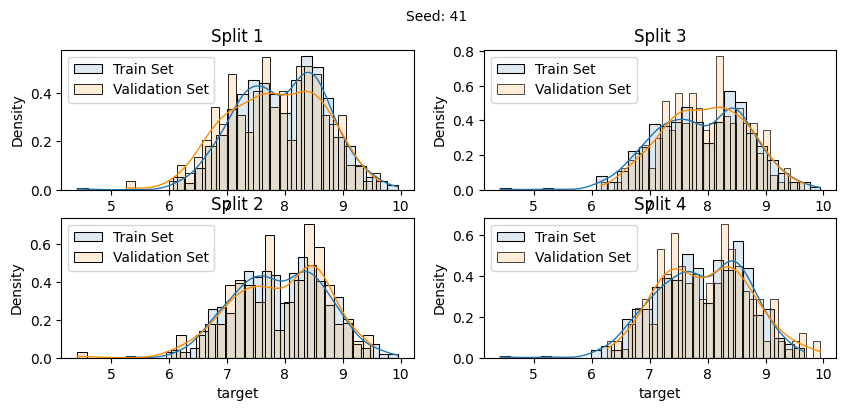

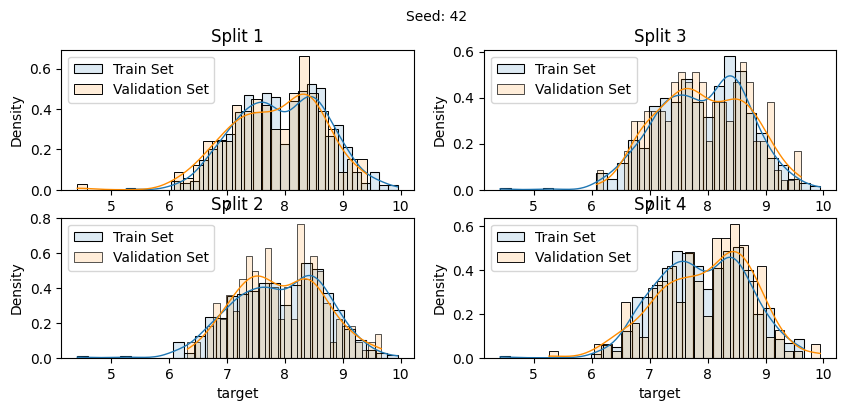

In [86]:
labels = y_train.reset_index(drop=True)

for i in [41, 42]:
    baseline_kfold = list(KFold(4,
                                shuffle=True,
                                random_state=i
                               ).split(labels))
    fold_visualizer(data=labels,
                    fold_idxs=baseline_kfold,
                    seed_num=i)

In [87]:
# Define the parameter grid for random search
param_rf = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, X_train.shape[1] + 1)
}

# Initialize Random Forest model
rf_model=RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, 
                                   param_distributions=param_rf,
                                   n_iter=10, 
                                   cv=5, 
                                   scoring='neg_mean_squared_error', 
                                   random_state=42)

In [88]:
# Perform the random search on the training set
random_search.fit(X_train, y_train)

# Display the best parameters found by random search
print("Best Parameters:", random_search.best_params_)


Best Parameters: {'n_estimators': 719, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': 4}


In [89]:
# Display the cross-validated score with the best parameters
best_score = random_search.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score:.4f}")


Best Cross-Validated Mean Squared Error: -0.5828


In [90]:
# Evaluate the model
score=evaluate_rf(random_search, 
                  X_train, 
                  X_test, 
                  y_train, 
                  y_test)
score

{'train r2': 0.2619315841174903,
 'test r2': 0.07142320481781617,
 'train mse': 0.4412672185882206,
 'test mse': 0.5535998912591864}

### Random Forest with Stratification

In [91]:
def train_test_stratified(df, n_quantiles=20, train_size=0.8, seed=42):
    # Step 1: Divide the DataFrame into quantiles
    quantiles = pd.qcut(df['target'], q=n_quantiles, labels=False)
    # Step 2: Randomly sample 80% of the data from each quantile for training
    train_data = pd.concat([group.sample(frac=train_size, random_state=seed) for _, group in df.groupby(quantiles)])
    # The remaining 20% will be used for testing
    test_data = df.drop(train_data.index)
    train_data = shuffle(train_data)
    test_data = shuffle(test_data)
    # Step 3: Already divide by features and target variables
    X_train, y_train = train_data.drop(columns=['target']), train_data['target']
    X_test, y_test = test_data.drop(columns=['target']), test_data['target']
    return X_train, X_test, y_train, y_test

In [92]:
X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified = train_test_stratified(df=train_df)

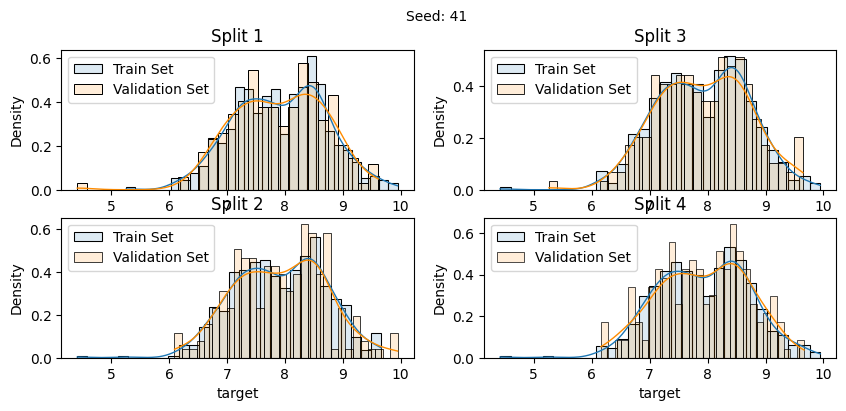

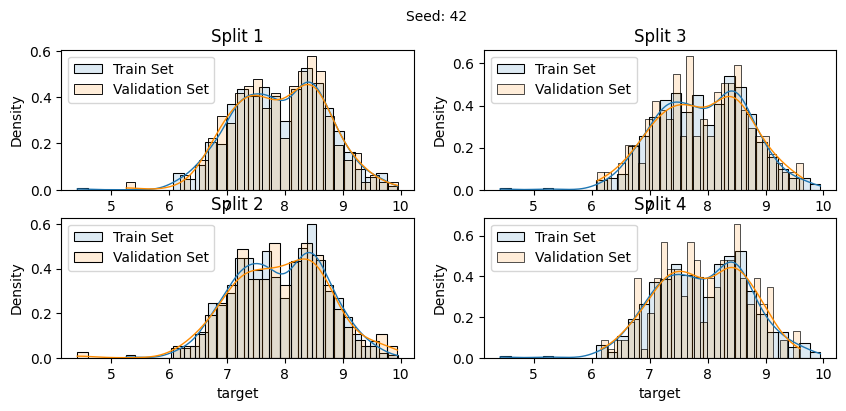

In [93]:
num_of_folds = 4
num_of_groups = 10
labels = y_train_stratified.reset_index(drop=True)

for i in [41, 42]:
    cv_splits = create_cont_folds(labels, 
                                  n_folds=num_of_folds, 
                                  n_groups=num_of_groups, 
                                  seed=i)
    fold_visualizer(data=labels,
                    fold_idxs=cv_splits,
                    seed_num=i)

In [94]:
n_folds=5
n_groups=20
# take the same training test data as before in stratification for trining/test
labels = y_train_stratified 

#cv splits
cv_splits_training = create_cont_folds(labels, 
                                       n_folds=n_folds, 
                                       n_groups=n_groups, 
                                       seed=42)

# Initialize Random Forest model
rf_model_stratified=RandomForestRegressor(random_state=42)

param_rf_stratified = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, X_train.shape[1] + 1)
}
# Initialize RandomizedSearchCV
random_search_stratified = RandomizedSearchCV(estimator=rf_model_stratified, 
                                            param_distributions=param_rf_stratified,
                                            n_iter=10, 
                                            cv = cv_splits_training, 
                                            scoring='neg_mean_squared_error', 
                                            random_state=42)

In [95]:
# check that cv splits worked correctly
test_dat=[]
for index, value in enumerate(cv_splits_training):
    test_dat.extend(value[1])
num_unique_numbers = len(set(test_dat))
print(f"Number of unique numbers: {num_unique_numbers}")

Number of unique numbers: 800


In [96]:
# Perform the random search on the training set
random_search_stratified.fit(X_train_stratified, y_train_stratified) 

# Display the best parameters found by random search
print("Best Parameters:", random_search_stratified.best_params_)

# Display the cross-validated score with the best parameters
best_score_stratified = random_search_stratified.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score_stratified:.4f}")

Best Parameters: {'n_estimators': 719, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': 4}

Best Cross-Validated Mean Squared Error: -0.5911


In [97]:
score_stratified=evaluate_rf(random_search_stratified, 
                             X_train_stratified, 
                             X_test_stratified, 
                             y_train_stratified, 
                             y_test_stratified)
score_stratified

{'train r2': 0.2591359311892433,
 'test r2': 0.061560499450853845,
 'train mse': 0.4502287868912026,
 'test mse': 0.5230174137504052}

Without stratification: 
* 'train r2': 0.475381505170395,
* 'test r2': -0.10115865862489093,
* 'train mse': 0.30848147510968865,
* 'test mse': 0.5465371738707565